### Compare cerebellar volumes across datasets

#### Datasets
- NIMHANS
- QPN


In [36]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


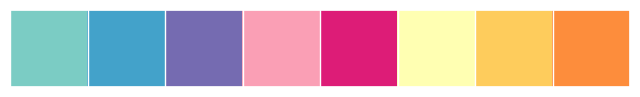

In [37]:
from enum import Enum
class my_colors(Enum):
    NIM_CONTROL = "#7bccc4"
    NIM_SERB_PD = "#43a2ca"
    NIM_METAL_PD = "#756bb1"
    QPN_CONTROL = "#fa9fb5"
    QPN_PD = "#dd1c77"
    PPMI_CONTROL = "#ffffb2"
    PPMI_PRODROMAL = "#fecc5c"
    PPMI_PD = "#fd8d3c"
    
color_list = [my_colors.NIM_CONTROL.value, my_colors.NIM_SERB_PD.value, my_colors.NIM_METAL_PD.value, 
              my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
              my_colors.PPMI_CONTROL.value, my_colors.PPMI_PRODROMAL.value, my_colors.PPMI_PD.value]

palette = sns.color_palette(palette=color_list) #sns.husl_palette()

hue_order = ["NIMHANS_SERB-control", "NIMHANS_SERB-PD", "NIMHANS_METAL-PD", "QPN-control", "QPN-PD"]
            #  "PPMI-control", "PPMI-prodromal", "PPMI-PD"]

sns.palplot(palette)

In [59]:
projects_dir = f"/home/nikhil/projects/Parkinsons//neuro_arch/analysis" 

nimhans_serb_agg_data_dir = f"{projects_dir}/derived_data/nimhans_serb/agg_dfs/"
nimhans_metal_agg_data_dir = f"{projects_dir}/derived_data/nimhans_metal/agg_dfs/"
qpn_agg_data_dir = f"{projects_dir}/derived_data/qpn/agg_dfs/"
ppmi_agg_data_dir = f"{projects_dir}/derived_data/ppmi/agg_dfs/"

CB_vol_csv = "cerebellar_volumes.csv"

global_vol_csv = "global_vol_ASEG_df.csv"

# save dirs
figs_dir = "/home/nikhil/projects/Parkinsons/neuro_arch/analysis/figures/"

demo_cols = ["participant_id","bids_id","age","sex","group","hemi","dataset", "eTIV"]

### Read global volumes (i.e. ASEG and demo df)

In [60]:
match_age = True
age_thresh = 63

# NIMHANS_SERB
nimhans_serb_global_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_global_ASEG_df["dataset"] = "NIMHANS_SERB"
n_nimhans_serb_participants = len(nimhans_serb_global_ASEG_df["participant_id"].unique())

# NIMHANS_METAL
nimhans_metal_global_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_global_ASEG_df["dataset"] = "NIMHANS_METAL"
n_nimhans_metal_participants = len(nimhans_metal_global_ASEG_df["participant_id"].unique())

# QPN
qpn_global_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_global_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"filter age < {age_thresh}")
    qpn_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"] < age_thresh]
    n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())
    print(f"n_nimhans_participants: {(n_nimhans_serb_participants)}, n_qpn_participants:{n_qpn_participants}")


nimhans_serb_demo_df = nimhans_serb_global_ASEG_df[demo_cols]
nimhans_metal_demo_df = nimhans_metal_global_ASEG_df[demo_cols]
qpn_demo_df = qpn_global_ASEG_df[demo_cols]

nimhans_serb_demo_df.head()

n_nimhans_participants: (86, 66), n_qpn_participants:201
filter age < 63
n_nimhans_participants: 86, n_qpn_participants:81


KeyError: "['eTIV'] not in index"

### Get merged cerebellar volumes + demo df

In [40]:
cerebellar_lobules = ['I_II', 'III', 'IV', 'V', 'VI', 'Crus_I', 'Crus_II','VIIB', 'VIIIA', 'VIIIB', 'IX', 'X', 'CM']

def merge_CB_demo_df(CB_df, demo_df, cerebellar_lobules):
    left_lobules = list("L_" + pd.Series(cerebellar_lobules))
    right_lobules = list("R_" + pd.Series(cerebellar_lobules))
    lh_lobule_dict = dict(zip(left_lobules,cerebellar_lobules))
    rh_lobule_dict = dict(zip(right_lobules,cerebellar_lobules))

    CB_df["bids_id"] = CB_df["Subject"].str.rsplit("/", expand=True)[3].str.split("_", expand=True)[0]
    # CB_df["participant_id"] = CB_df["bids_id"].str.split("-", expand=True)[1]

    # merge with demo
    CB_demo_df = pd.merge(CB_df, demo_df, on="bids_id", how="inner")
    CB_demo_df = CB_demo_df.drop(columns=["Subject"])

    demo_cols = list(set(CB_demo_df.columns) - set(left_lobules) - set(right_lobules))

    left_CB_df = CB_demo_df[demo_cols + left_lobules].copy()
    left_CB_df["hemi"] = "left"
    right_CB_df = CB_demo_df[demo_cols + right_lobules].copy()
    right_CB_df["hemi"] = "right"

    # add total CB vol column
    left_CB_df["total_CB_vol"] = left_CB_df[left_lobules].sum(axis=1)
    right_CB_df["total_CB_vol"] = right_CB_df[right_lobules].sum(axis=1)

    # rename columns to stack vertically
    left_CB_df = left_CB_df.rename(columns=lh_lobule_dict)
    right_CB_df = right_CB_df.rename(columns=rh_lobule_dict)
    
    CB_demo_df = pd.concat([left_CB_df, right_CB_df], axis=0)

    return CB_demo_df

In [41]:
# nimhans-serb
nimhans_serb_CB_vols_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}/{CB_vol_csv}")
nimhans_serb_CB_vols_df = merge_CB_demo_df(nimhans_serb_CB_vols_df, nimhans_serb_demo_df, cerebellar_lobules)

# nimhans-metal
nimhans_metal_CB_vols_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}/{CB_vol_csv}")
nimhans_metal_CB_vols_df = merge_CB_demo_df(nimhans_metal_CB_vols_df, nimhans_metal_demo_df, cerebellar_lobules)

# qpn
qpn_CB_vols_df = pd.read_csv(f"{qpn_agg_data_dir}/{CB_vol_csv}")
qpn_CB_vols_df = merge_CB_demo_df(qpn_CB_vols_df, qpn_demo_df, cerebellar_lobules)


CB_vol_df = pd.concat([nimhans_serb_CB_vols_df, nimhans_metal_CB_vols_df, qpn_CB_vols_df], axis=0)
CB_vol_df["ds_group"] = CB_vol_df["dataset"] + "-" + CB_vol_df["group"]
print(f"CB_vol_df shape: {CB_vol_df.shape}")
CB_vol_df.head()

CB_vol_df shape: (462, 22)


,age,sex,participant_id,dataset,bids_id,hemi,group,I_II,III,IV,...,Crus_I,Crus_II,VIIB,VIIIA,VIIIB,IX,X,CM,total_CB_vol,ds_group
0,60.0,M,SERB004,NIMHANS_SERB,sub-SERB004,left,control,73.9998,588.999,1878.0,...,8909.98,5652.99,2768.99,4209.99,3256.99,3263.99,450.999,7470.98,47297.8878,NIMHANS_SERB-control
1,NaN,NaN,SERB002,NIMHANS_SERB,sub-SERB002,left,control,62.0000,724.000,2013.0,...,10837.00,8699.00,4216.00,5801.00,3125.00,3726.00,541.000,7966.00,57313.0000,NIMHANS_SERB-control
2,47.0,M,SERB003,NIMHANS_SERB,sub-SERB003,left,control,77.0000,873.000,1985.0,...,10330.00,6189.00,3279.00,5076.00,2997.00,2454.00,459.000,7560.00,51935.0000,NIMHANS_SERB-control
3,56.0,M,SERB001,NIMHANS_SERB,sub-SERB001,left,control,58.0000,804.000,2243.0,...,10737.00,6656.00,3175.00,5106.00,3515.00,3331.00,579.000,10112.00,56311.0000,NIMHANS_SERB-control
4,NaN,NaN,SERB005,NIMHANS_SERB,sub-SERB005,left,control,58.0000,656.000,1722.0,...,8103.00,6054.00,3090.00,4079.00,2498.00,2490.00,511.000,6702.00,46298.0000,NIMHANS_SERB-control


### Plots

/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

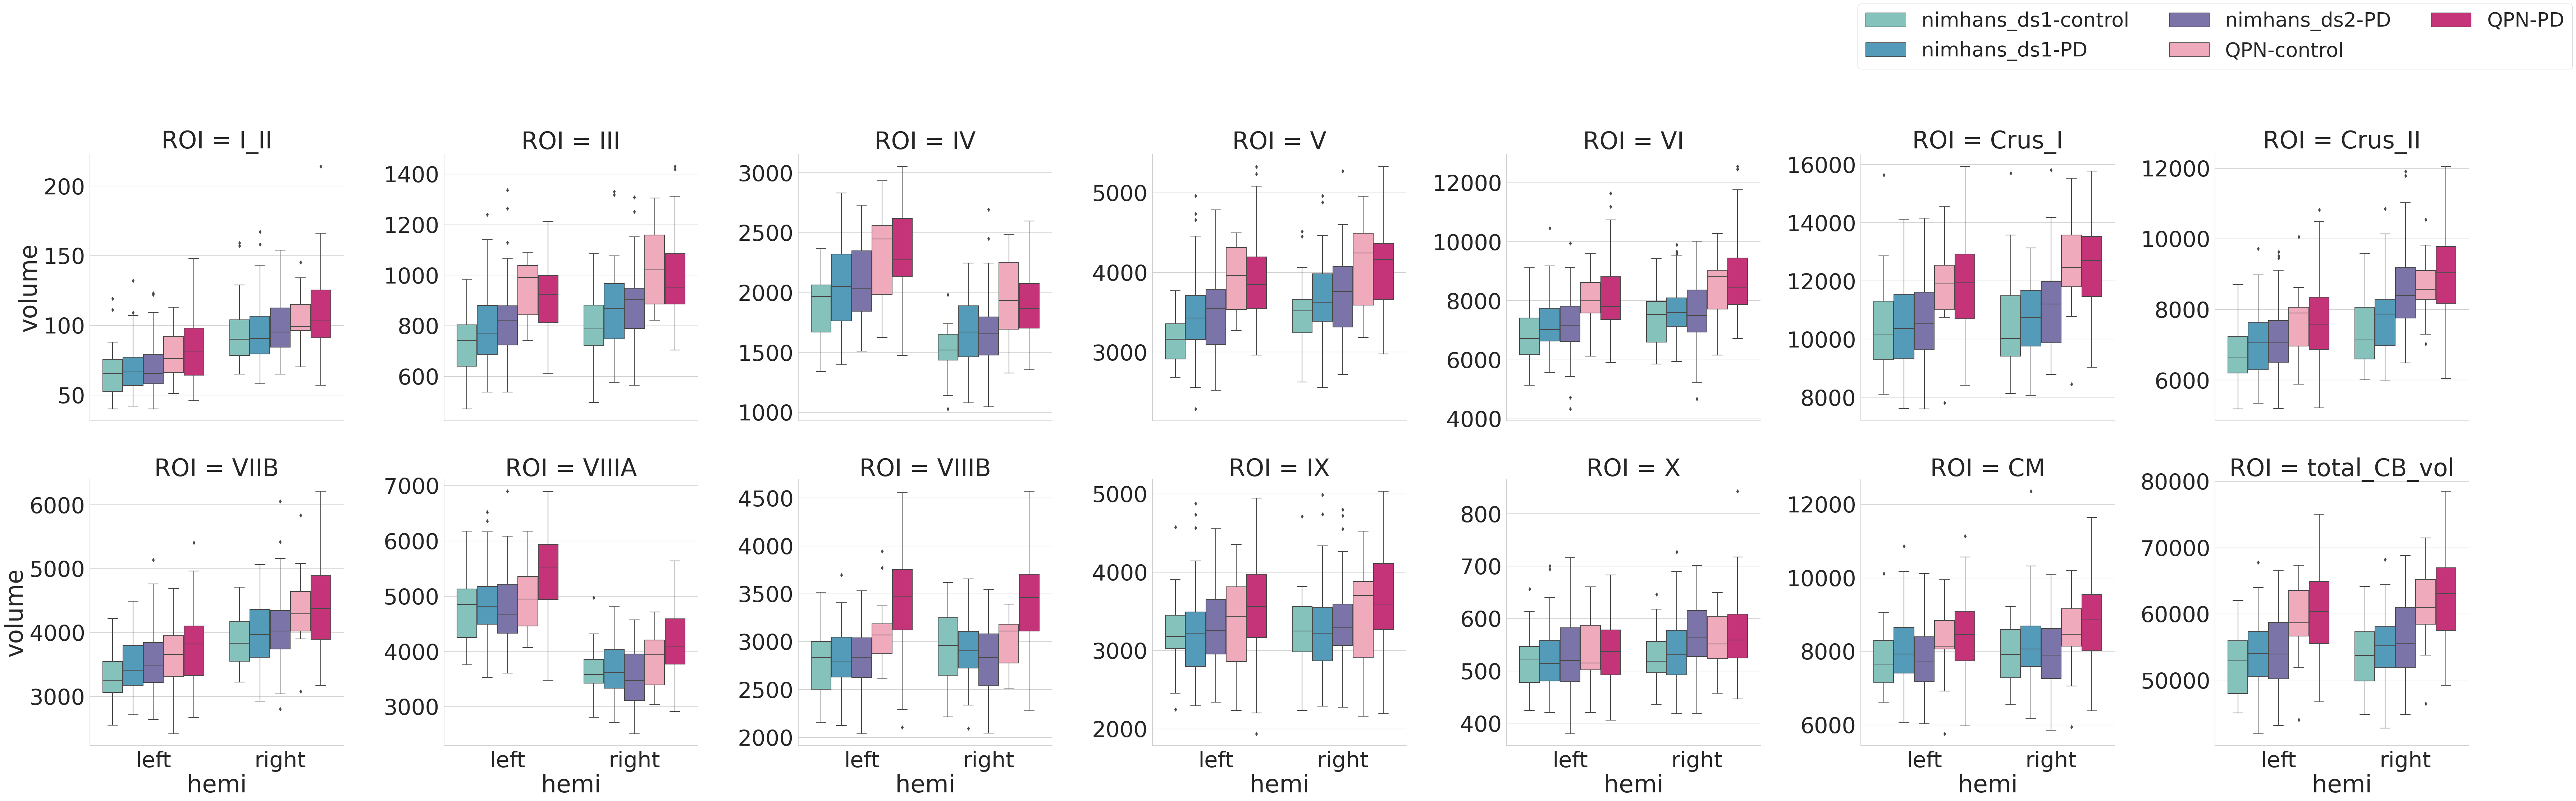

In [42]:
save_fig = False

CB_vol_df_melt = CB_vol_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = CB_vol_df_melt.copy()

plot_df["ds_group"] = plot_df["ds_group"].replace({"NIMHANS_SERB-control":"nimhans_ds1-control", 
                                                    "NIMHANS_SERB-PD":"nimhans_ds1-PD", 
                                                    "NIMHANS_METAL-PD":"nimhans_ds2-PD"})

hue_order = ["nimhans_ds1-control", "nimhans_ds1-PD", "nimhans_ds2-PD", "QPN-control", "QPN-PD"]
sns.set(font_scale=4)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI", kind="box", col_wrap=7, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    # plt.legend(bbox_to_anchor =(1.7,0.1), loc='lower center',ncol=1, fontsize=40)
    plt.legend(bbox_to_anchor =(0,2.5), loc='lower center',ncol=3, fontsize=40)
if save_fig:
    g.savefig(f"{figs_dir}/CB_vol.png")

In [43]:
CB_vol_df.groupby(["dataset","group"])["participant_id"].count()

dataset        group  
NIMHANS_METAL  PD         132
NIMHANS_SERB   PD         124
               control     44
QPN            PD         136
               control     26
Name: participant_id, dtype: int64

In [44]:
CB_vol_df.groupby(["dataset","group"])["age"].describe()

count       mean        std   min   25%   50%    75%  \
dataset       group                                                           
NIMHANS_METAL PD       118.0  53.644068  10.089790  24.0  46.0  55.0  61.00   
NIMHANS_SERB  PD       106.0  55.283019   7.190940  36.0  50.0  56.0  61.00   
              control   30.0  52.000000   5.907330  41.0  48.5  53.0  56.75   
QPN           PD       136.0  55.961765   5.279760  40.9  53.2  57.1  60.05   
              control   26.0  52.515385   7.628247  37.7  49.8  55.4  57.60   

                        max  
dataset       group          
NIMHANS_METAL PD       72.0  
NIMHANS_SERB  PD       67.0  
              control  60.0  
QPN           PD       62.9  
              control  62.6

### Statistical tests: OLS

In [45]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [61]:
def get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction=False):
    cvar_str = ""
    for cvar in cat_vars:
        cvar_str = "".join([f"{cvar_str} + C({cvar})"])    

    if global_correction:
        formula = f"{ind_var} ~ {dep_var}{cvar_str} + {global_correction}"
    else:
        formula = f"{ind_var} ~ {dep_var}{cvar_str}"
        
    res = smf.ols(formula=formula, data=stat_df).fit()
    
    tval_df = pd.DataFrame(columns=["tvalues"], data=res.tvalues)
    pval_df = pd.DataFrame(columns=["pvalues"], data=res.pvalues)
    res_df = pd.concat([tval_df, pval_df], axis=1)
    res_df = res_df.reset_index().rename(columns={"index":"var"})

    return res_df, res, formula

### Replication analysis

In [49]:
dep_var = "age"
cat_vars = ["sex", "group"]
dataset_list = ["NIMHANS_SERB","QPN"]

pval_thresh = 0.05

In [57]:
brain_roi_list = ['IandII', 'III', 'IV', 'V', 'VI', 'CrusI', 'CrusII','VIIB', 'VIIIA', 'VIIIB', 'IX', 'X', 'CM']
hemi_list = ["left", "right"]
global_correction = "total_CB_vol"

CB_vol_df = CB_vol_df.rename(columns={"I_II":"IandII", 'Crus_I':'CrusI', 'Crus_II':'CrusII'})


res_df = pd.DataFrame()
for ds in dataset_list:
    for ind_var in brain_roi_list:
        for hemi in hemi_list:
            # print(f"ds:{ds}, ind_var:{ind_var}")
            stat_df = CB_vol_df.copy()
            stat_df = stat_df[(stat_df["dataset"]==ds) & (stat_df["hemi"]==hemi)]
            if global_correction:
                _df = get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction)
            else:
                _df = get_stats(stat_df, ind_var, dep_var, cat_vars)
            _df["ROI"] = ind_var
            _df["hemi"] = hemi
            _df["dataset"] = ds
            res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

,var,tvalues,pvalues,ROI,hemi,dataset
2,C(group)[T.control],-2.306451,0.024334,III,left,NIMHANS_SERB
2,C(group)[T.control],-2.622022,0.010911,III,right,NIMHANS_SERB
2,C(group)[T.control],-2.021418,0.047423,IV,left,NIMHANS_SERB
2,C(group)[T.control],-2.544347,0.013372,IV,right,NIMHANS_SERB
2,C(group)[T.control],-2.282782,0.025775,V,left,NIMHANS_SERB
2,C(group)[T.control],-2.240353,0.028547,VIIB,left,NIMHANS_SERB
2,C(group)[T.control],-2.049303,0.043839,VIIIA,left,QPN
2,C(group)[T.control],-2.794615,0.006555,VIIIB,right,QPN


In [58]:
res_df

,var,tvalues,pvalues,ROI,hemi,dataset
0,Intercept,2.177325,3.315029e-02,IandII,left,NIMHANS_SERB
1,C(sex)[T.M],2.300185,2.470839e-02,IandII,left,NIMHANS_SERB
2,C(group)[T.control],-0.210615,8.338570e-01,IandII,left,NIMHANS_SERB
3,age,1.064686,2.910184e-01,IandII,left,NIMHANS_SERB
0,Intercept,2.718931,8.419689e-03,IandII,right,NIMHANS_SERB
...,...,...,...,...,...,...
3,age,-2.846329,5.665721e-03,CM,left,QPN
0,Intercept,9.796201,3.542805e-15,CM,right,QPN
1,C(sex)[T.M],4.244871,6.046944e-05,CM,right,QPN
2,C(group)[T.control],-0.391868,6.962385e-01,CM,right,QPN
